# Planetary Variables
## Forest carbon Diligence
### Extracting polygon-level time-series 

This Jupyter Notebook demonstrates how to derive time-series of statistics from the [Forest Carbon Diligence](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/forest-carbon-diligence/) product using a combination of Sentinel Hub's [Statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/) and [Processing API](https://docs.sentinel-hub.com/api/latest/api/process/).

Statistics (more details below) will be produced for the different variables contained in the Forest Carbon Diligence product:

- _Canopy Height_: quantifies the average height of all vegetation per pixel;
- _Canopy Cover_: quantifies the horizontal area occupied by tree canopies that are > 5 m tall;
- _Aboveground carbon density_: quantifies the density of carbon stored in woody vegetation, primarily trees and shrubs;
- _Biomass_: converted from aboveground carbon density.

The examples produced in this Jupyter Notebook are divided into four steps.

1. After plotting the parcel of interest (imported from a geoJSON file) on a map, we will extract the following statistics using Sentinel Hub's Statistical API:

- Minimum;
- Maximum;
- Average;
- Standard deviation;
- Data/No Data count

2. In a second step, we will use Sentinel Hub's Processing API to extract the sum of aboveground carbon density and biomass over the parcel of interest.

3. Thirdly, we will show how to query the same statistics as in step 1, but masking non-forested areas out. The forest mask is derived from a combination of height and cover thresholds: for the purpose of this demonstration, forested areas are considered as pixel with `Canopy Height > 5 m` and `Canopy Cover > 15%` (note that these thresholds can be changed in the script).
4. We will use Processing API to plot the Canopy Height over the parcel of interest at two different dates. The dates will be chosen based on the time series previously plotted, highlighting how a combination of statistics and visualisation of products can support the analysis of various phenomena.

In [38]:
import getpass
import json
import folium
import pyproj

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.ops import transform

from sentinelhub import (
    SHConfig,
    geometry,
    CRS,
    SentinelHubStatistical,
    DataCollection,
    MimeType,
    SentinelHubRequest
    )

## Credentials

To obtain your `client_id` & `client_secret`, you need to navigate to your [Dashboard](https://apps.sentinel-hub.com/dashboard/#/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding [documentation page](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook.

Currently, the following cell is set up in a way that you need to specify your `client_id` & `client_secret` when running it.


In [ ]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
    config.sh_client_id = getpass.getpass("sh_client_id: ")
    config.sh_client_secret = getpass.getpass("sh_client_secret: ")
    config.save()
    print(f"Credentials saved to {SHConfig.get_config_location()}")
else:
    print(f"Using credentials stored here: {SHConfig.get_config_location()}")

## Set collection IDS

The [Forest Carbon Diligence](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/forest-carbon-diligence/) layers are available as subscriptions through Sentinel Hub's [TPDI](https://docs.sentinel-hub.com/api/latest/api/data-import/) service. Once the area of interest and variables are subscribed to, the data are then automatically imported into Sentinel Hub and available by specifying the Collection ID. 

In this example, we will use the collection IDs available from Planet's Sandbox Data page for Forest Carbon Diligence. 

A collection ID will allow you to retrieve the data from the collection, just as you would with a standard dataset (e.g. Sentinel-2). For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).


<div style="width: 75%; padding: 15px; border: 2px solid #007980; border-radius: 5px; background-color: transparent; margin-left: 0;">
  <div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="display: flex; align-items: center; flex: 0 0 50%; padding-right: 20px;">
      <svg style="margin-right: 10px; fill: #007980; width: 64px; height: 64px;" viewBox="0 0 24 24">
        <path d="M11,9H13V7H11M12,20C7.59,20 4,16.41 4,12C4,7.59 7.59,4 12,4C16.41,4 20,7.59 20, 12C20,16.41 16.41,20 12,20M12,2A10,10 0 0,0 2,12A10,10 0 0,0 12,22A10,10 0 0,0 22,12A10, 10 0 0,0 12,2M11,17H13V11H11V17Z"></path>
      </svg>
      <p style="font-size: 16px; margin: 0; line-height: 1.5;">
        This notebook makes use of <a href="https://collections.sentinel-hub.com/planet-sandbox-data/" target="_blank">Planet Sandbox Data</a>. You need a Planet account in order to access this data. If you don't already have an account, you can <a href="https://www.sentinel-hub.com/create_account/" target="_blank">create a free 30 day trial</a>.
      </p>
    </div>
    <div style="flex: 0 0 50%; display: flex; justify-content: center; align-items: center;">
      <a href="https://www.sentinel-hub.com/create_account/" target="_blank" style="
        display: inline-block;
        padding: 10px 20px;
        font-size: 16px;
        font-weight: bold;
        color: #fff;
        background-color: #007980;
        border-radius: 5px;
        text-decoration: none;
        white-space: nowrap;
        transition: background-color 0.3s ease;
        margin: 0 auto;
      " onmouseover="this.style.backgroundColor='#005960'" onmouseout="this.style.backgroundColor='#007980'">
        Start Free Trial
      </a>
    </div>
  </div>
</div>


In [41]:
# Replace with your own collection IDs
height_collection = DataCollection.define_byoc("f3312c82-edea-42a1-8c9d-ada86ddcc857")

cover_collection = DataCollection.define_byoc("e3d2a21c-cb75-4311-86ac-024385c85b9c")

carbon_collection = DataCollection.define_byoc("cc31cada-80d8-46fe-a746-43ac2f87b5da")


## Area of Interest

First, we define an area of interest, located close to São Félix do Xingu, in Brazil.

In this example, the area of interest is defined in a GeoJSON file in EPSG:3857. We will read the geoJSON and plot the area of interest on an interactive map.

You can also explore the area of interest in Sentinel Hub's [EO Browser](https://sentinelshare.page.link/XN9P).

In [42]:
# Read a geojson containing a polygon representing a parcel of interest
parcel_data = json.loads(open("./aoi.geojson").read())
parcel_polygon = Polygon(parcel_data["features"][0]["geometry"]["coordinates"][0])

# Convert to a Sentinel Hub geometry
parcel_geo = geometry.Geometry(parcel_polygon, crs=CRS(3857))

del parcel_data

In [43]:
# Convert Polygon to EPSG 4326 for mapping
project = pyproj.Transformer.from_proj(
    pyproj.Proj("epsg:3857"),  # source coordinate system
    pyproj.Proj("epsg:4326"),
    always_xy=True,
)
reproj_poly = transform(project.transform, parcel_polygon)

# Plot the parcel on an interactive map
m = folium.Map(
    location=[
        reproj_poly.centroid.coords.xy[1][0],
        reproj_poly.centroid.coords.xy[0][0],
    ],
    zoom_start=11,
    tiles="OpenStreetMap",
)
geo_j = folium.GeoJson(data=reproj_poly, style_function=lambda x: {"fillColor": "blue"})
geo_j.add_to(m)
m

## 1. Extract statistics

In the following cells we will extract statistics using Sentinel Hub's [Statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/) and parse the results into a Dataframe, making it easier to analyse and plot the results. (Tip: learn more about the API in our [webinar](https://www.youtube.com/watch?v=4JviobxqTO8)).

Results of Statistical API are aggregated statistical values of satellite data instead of entire images. By using Statistical API we can avoid downloading and processing large amounts of satellite data. All general rules for building [Evalscripts](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://docs.sentinel-hub.com/api/latest/api/statistical/#exclude-pixels-from-calculations-datamask-output).
- The default value of `sampleType` is `FLOAT32`.
- The `output.bands` parameter in the `setup()` function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

In [44]:
evalscript_statistics = """
//VERSION=3

const BIOMASS_CONV = 0.476;

function setup() {
    return {
        input: [{
            datasource: "canopyHeight",
            bands: ["CH", "dataMask"]
        },
        {
            datasource: "canopyCover",
            bands: ["CC", "dataMask"]
        },
        {
            datasource: "carbon",
            bands: ["ACD", "dataMask"]
        }
        ],
        output: [
            { id: "canopyHeight", bands: 1, sampleType: "UINT8" },
            { id: "canopyCover", bands: 1, sampleType: "UINT8" },
            { id: "carbon", bands: 1, sampleType: "UINT16" },
            { id: "biomass", bands: 1, sampleType: "FLOAT32" },
            { id: "dataMask", bands: 1, sampleType: "UINT8" }
        ],
        mosaicking: "ORBIT"
    };
}

function evaluatePixel(samples) {
    var sampleHeight = samples.canopyHeight[0].CH
    var nodataHeight = samples.canopyHeight[0].dataMask
    var sampleCover = samples.canopyCover[0].CC
    var nodataCover = samples.canopyCover[0].dataMask
    var sampleCarbon = samples.carbon[0].ACD
    var nodataCarbon = samples.carbon[0].dataMask

    // Biomass simple scalar conversion
    var sampleBiomass = sampleCarbon / BIOMASS_CONV


    // Combined noData mask
    var allMask = nodataHeight * nodataCover * nodataCarbon

    return {
        canopyHeight: [sampleHeight],
        canopyCover: [sampleCover],
        carbon: [sampleCarbon],
        biomass: [sampleBiomass],
        dataMask: [allMask]
    };
}
"""

In [45]:
# Start year and end year
start_year = 2013
end_year = 2017

# Payload
request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript_statistics,
        time_interval=(f"{start_year}-01-01T00:00:00Z", f"{end_year}-12-31T23:59:59Z"),
        # To fetch the yearly data that is set to 1 date / year we set the aggregation to P1D
        aggregation_interval="P1D",
        # Match the resolution of the PV (30 meters). Beware: resolution should be in the units of the coordinate system used
        resolution=[30, 30],
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            # Note that we set the service_url to the US-West-2 (Oregon) region since the data are stored there
            height_collection,
            identifier="canopyHeight",
        ),
        SentinelHubStatistical.input_data(
            cover_collection,
            identifier="canopyCover",
        ),
        SentinelHubStatistical.input_data(
            carbon_collection,
            identifier="carbon",
        ),
    ],
    geometry=parcel_geo,
    config=config,
)

In [46]:
# Run the request and display a sample of the data returned
statistical_response = request.get_data()
statistical_response

[{'data': [{'interval': {'from': '2013-01-01T00:00:00Z',
     'to': '2013-01-02T00:00:00Z'},
    'outputs': {'biomass': {'bands': {'B0': {'stats': {'min': 0.0,
         'max': 237.39495849609375,
         'mean': 99.2044952589687,
         'stDev': 66.8899298416422,
         'sampleCount': 51975,
         'noDataCount': 27551}}}},
     'carbon': {'bands': {'B0': {'stats': {'min': 0.0,
         'max': 113.0,
         'mean': 47.22133966590254,
         'stDev': 31.83960647307928,
         'sampleCount': 51975,
         'noDataCount': 27551}}}},
     'canopyHeight': {'bands': {'B0': {'stats': {'min': 0.0,
         'max': 29.0,
         'mean': 10.778332787422176,
         'stDev': 8.594439558491416,
         'sampleCount': 51975,
         'noDataCount': 27551}}}},
     'canopyCover': {'bands': {'B0': {'stats': {'min': 0.0,
         'max': 95.0,
         'mean': 55.66483786439556,
         'stDev': 34.25824855830473,
         'sampleCount': 51975,
         'noDataCount': 27551}}}}}},
   {

### Sorting the data

As you can see in the cell above, the Statistical API returns a json structure with the results of the query. This format isn't easy to plot or filter: to make the data easier to work with, we will convert it into a tabular form using a `pandas` dataframe.

In [47]:
# Convert to geopandas
forest_df = pd.json_normalize(statistical_response[0]['data'])

# Populate a year column
forest_df['year'] = pd.to_datetime(forest_df['interval.from']).dt.year

# Drop unecessary columns
forest_df = forest_df.drop(columns=['interval.from', 'interval.to'])

# Rename columns
forest_df.columns = forest_df.columns.str.replace('outputs.', '').str.replace('.bands.B0.stats', '')

# Set index
forest_df.set_index('year', inplace=True)

# Show the new Dataframe with the results
forest_df

,biomass.min,biomass.max,biomass.mean,biomass.stDev,biomass.sampleCount,biomass.noDataCount,carbon.min,carbon.max,carbon.mean,carbon.stDev,...,canopyHeight.mean,canopyHeight.stDev,canopyHeight.sampleCount,canopyHeight.noDataCount,canopyCover.min,canopyCover.max,canopyCover.mean,canopyCover.stDev,canopyCover.sampleCount,canopyCover.noDataCount
year,,,,,,,,,,,,,,,,,,,,,
2013,0.0,237.394958,99.204495,66.889930,51975,27551,0.0,113.0,47.221340,31.839606,...,10.778333,8.594440,51975,27551,0.0,95.0,55.664838,34.258249,51975,27551
2014,0.0,226.890762,87.127588,63.982827,51975,27551,0.0,108.0,41.472732,30.455826,...,9.563790,8.123334,51975,27551,0.0,94.0,50.374099,32.254596,51975,27551
2015,0.0,222.689072,82.873094,60.979296,51975,27551,0.0,106.0,39.447593,29.026145,...,8.748976,7.889597,51975,27551,0.0,94.0,48.132452,31.535923,51975,27551
2016,0.0,220.588242,76.919021,63.382420,51975,27551,0.0,105.0,36.613454,30.170032,...,8.394612,8.464098,51975,27551,0.0,92.0,43.515026,32.353609,51975,27551
2017,0.0,203.781509,48.540559,50.265169,51975,27551,0.0,97.0,23.105306,23.926220,...,5.706682,6.726540,51975,27551,0.0,90.0,29.573698,30.010938,51975,27551


## Plot data

In the following cell, we will plot the average value over the parcel of interest for the 4 different variables returned from the Statistical API query over the time period 2013-2017. The standard deviation is represented by error bars for each year.

Looking at the graph, there appears to be a downward trend in all variables between 2013 and 2017, with a larger drop between 2016 and 2017. For example, the Canopy Cover decreases by around 12% between 2013 and 2016, but then by approximately 14% between 2016 and 2017, suggesting an increase in deforestation.

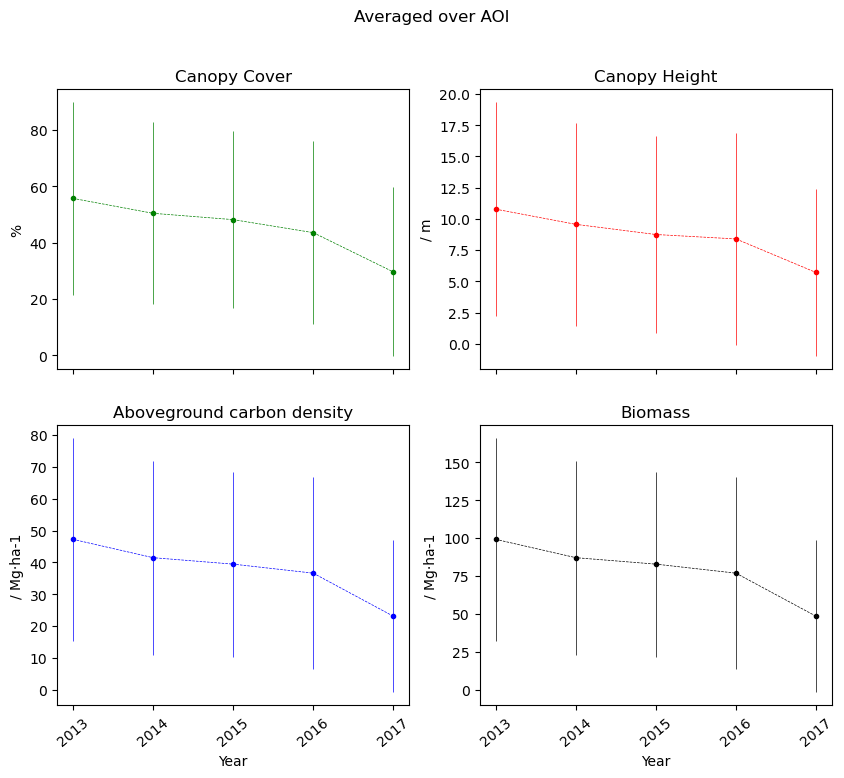

In [48]:
# Plot average values for the area of interest over time
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2, sharex=True)

# Cover
ax[0, 0].errorbar(
    forest_df.index,
    forest_df["canopyCover.mean"],
    forest_df["canopyCover.stDev"],
    linestyle="--",
    marker=".",
    color="g",
    linewidth=0.5,
)
ax[0, 0].set_title("Canopy Cover")
ax[0, 0].set_ylabel("%")

# Height
ax[0, 1].errorbar(
    forest_df.index,
    forest_df["canopyHeight.mean"],
    forest_df["canopyHeight.stDev"],
    linestyle="--",
    marker=".",
    color="r",
    linewidth=0.5,
)
ax[0, 1].set_title("Canopy Height")
ax[0, 1].set_ylabel("/ m")

# Carbon
ax[1, 0].errorbar(
    forest_df.index,
    forest_df["carbon.mean"],
    forest_df["carbon.stDev"],
    linestyle="--",
    marker=".",
    color="b",
    linewidth=0.5,
)
ax[1, 0].set_title("Aboveground carbon density")
ax[1, 0].set_ylabel("/ Mg⋅ha-1")
ax[1, 0].set_xlabel("Year")


# Biomass
ax[1, 1].errorbar(
    forest_df.index,
    forest_df["biomass.mean"],
    forest_df["biomass.stDev"],
    linestyle="--",
    marker=".",
    color="k",
    linewidth=0.5,
)
ax[1, 1].set_title("Biomass")
ax[1, 1].set_ylabel("/ Mg⋅ha-1")
ax[1, 1].set_xlabel("Year")


for axl in [ax[1, 0], ax[1, 1]]:
    axl.tick_params(axis="x", labelrotation=40)

fig.suptitle("Averaged over AOI")
plt.show()

## Compute sum of carbon and biomass

In a second step, we will use Sentinel Hub's Processing API to extract the sum of aboveground carbon density and biomass over the parcel of interest. Indeed, Sentinel Hub's statistical API doesn't return the sum of the pixels contained in a geometry, so we will use Process API to write the values to a json file.

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/api/process/), using the `SentinelHubRequest` class from the `sentinelhub-py` [Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html). Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/). 

The subtlety in this request is that we will pass the cumulative carbon and biomass values to the `userdata` object that is a property of the [outputMetadata](https://docs.sentinel-hub.com/api/latest/evalscript/v3/#outputmetadata), sparing us to have to return an image, and thus only accessing the statistics needed for this analysis.

In [49]:
evalscript_sum = """
//VERSION=3
function setup() {
    return {
        input: ["ACD", "dataMask"],
        output: { bands: 1, sampleTYPE: "UINT8" },
        mosaicking: "ORBIT"
    }
}

// Initialise sum variables
var sumVariables = {};

// Set constants
const BIOMASS_CONV = 0.476

function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
    // Write the output to a metadata file
    outputMetadata.userData = sumVariables
}

function evaluatePixel(samples, scenes, inputMetadata, customData, outputMetadata) {

    // Loop around samples
    samples.forEach((sample, index) => {
        if (sample.dataMask == 1) {
            // Populate the Object containing sum values by adding the pixel value or creating the entry if it doesn't exist
            if (sumVariables.hasOwnProperty(scenes[index].date.getFullYear())) {
                sumVariables[scenes[index].date.getFullYear()]["carbon"]["sum"] += sample.ACD
                sumVariables[scenes[index].date.getFullYear()]["biomass"]["sum"] += sample.ACD / BIOMASS_CONV
            } else {
                sumVariables[scenes[index].date.getFullYear()] = { "carbon": { "sum": sample.ACD }, "biomass": { "sum": sample.ACD / BIOMASS_CONV } }
            }
        }
    });
}
"""

In [50]:
# Payload
carbonsum = SentinelHubRequest(
    evalscript=evalscript_sum,
    input_data=[
        # Set the collection containing Aboveground Carbon Density, Forest Carbon Diligence 
        # Here we fetch data from 2013 to 2017
        SentinelHubRequest.input_data(
            data_collection=carbon_collection,
            time_interval=(f"{start_year}-01-01", f"{end_year}-01-01"),
        )
    ],
    # We return 2 outputs: "default" which will be empty and "userdata" which will contain the metadata requested in the Evalscript
    responses=[
        SentinelHubRequest.output_response("default", MimeType.PNG),
        SentinelHubRequest.output_response("userdata", MimeType.JSON),
    ],
    geometry=parcel_geo,
    # Match the resolution of the PV (30 meters). Beware: resolution should be in the units of the coordinate system used
    resolution=(30, 30),
    data_folder=".",
    config=config,
)

In [51]:
# Run the request and display a sample of the data returned
sum_response = carbonsum.get_data()
sum_response[0]['userdata.json']

{'2013': {'carbon': {'sum': 1153334}, 'biomass': {'sum': 2422970.5882354183}},
 '2014': {'carbon': {'sum': 1012930}, 'biomass': {'sum': 2128004.201680626}},
 '2015': {'carbon': {'sum': 963468}, 'biomass': {'sum': 2024092.4369747392}},
 '2016': {'carbon': {'sum': 894247}, 'biomass': {'sum': 1878670.1680671955}},
 '2017': {'carbon': {'sum': 564324}, 'biomass': {'sum': 1185554.6218487276}}}

### Sorting the data

Just as we did for the results coming from the Statistical API, we will convert the results into a tabular form using a `pandas` dataframe. To insert the data into the main dataframe, we will follow the same structure.

In [52]:
sum_response[0]

{'default.png': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'userdata.json': {'2013': {'carbon': {'sum': 1153334},
   'biomass': {'sum': 2422970.5882354183}},
  '2014': {'carbon': {'sum': 1012930}, 'biomass': {'sum': 2128004.201680626}},
  '2015': {'carbon': {'sum': 963468}, 'biomass': {'sum': 2024092.4369747392}},
  '2016': {'carbon': {'sum': 894247}, 'biomass': {'sum': 1878670.1680671955}},
  '2017': {'carbon': {'sum': 564324}, 'biomass': {'sum': 1185554.6218487276}}}}

In [53]:
# Convert to geopandas
carbon_df = pd.DataFrame()

for x in sum_response[0]['userdata.json']:
    df = pd.json_normalize(sum_response[0]['userdata.json'][x])
    df["year"] = int(x)
    carbon_df = pd.concat([carbon_df, df])
    
df = None
carbon_df.set_index('year', inplace=True)

# Display the dataFrame
carbon_df

,carbon.sum,biomass.sum
year,,
2013,1153334,2.422971e+06
2014,1012930,2.128004e+06
2015,963468,2.024092e+06
2016,894247,1.878670e+06
2017,564324,1.185555e+06


### Merge Dataframes from Statistical and Processing API

In the next cell, we will integrate the newly created Dataframe into the one created earlier from the Statistical API results.

In [54]:
statistics_df = forest_df.join(carbon_df)
statistics_df

,biomass.min,biomass.max,biomass.mean,biomass.stDev,biomass.sampleCount,biomass.noDataCount,carbon.min,carbon.max,carbon.mean,carbon.stDev,...,canopyHeight.sampleCount,canopyHeight.noDataCount,canopyCover.min,canopyCover.max,canopyCover.mean,canopyCover.stDev,canopyCover.sampleCount,canopyCover.noDataCount,carbon.sum,biomass.sum
year,,,,,,,,,,,,,,,,,,,,,
2013,0.0,237.394958,99.204495,66.889930,51975,27551,0.0,113.0,47.221340,31.839606,...,51975,27551,0.0,95.0,55.664838,34.258249,51975,27551,1153334,2.422971e+06
2014,0.0,226.890762,87.127588,63.982827,51975,27551,0.0,108.0,41.472732,30.455826,...,51975,27551,0.0,94.0,50.374099,32.254596,51975,27551,1012930,2.128004e+06
2015,0.0,222.689072,82.873094,60.979296,51975,27551,0.0,106.0,39.447593,29.026145,...,51975,27551,0.0,94.0,48.132452,31.535923,51975,27551,963468,2.024092e+06
2016,0.0,220.588242,76.919021,63.382420,51975,27551,0.0,105.0,36.613454,30.170032,...,51975,27551,0.0,92.0,43.515026,32.353609,51975,27551,894247,1.878670e+06
2017,0.0,203.781509,48.540559,50.265169,51975,27551,0.0,97.0,23.105306,23.926220,...,51975,27551,0.0,90.0,29.573698,30.010938,51975,27551,564324,1.185555e+06


## Plot data

In the next cell we will plot the sum of aboveground carbon and biomass (linearly derived from carbon) for the parcel of interest.

Similarly to the previous figure, there seems to be a downward trend in values over time, with a larger drop between 206 and 2017.

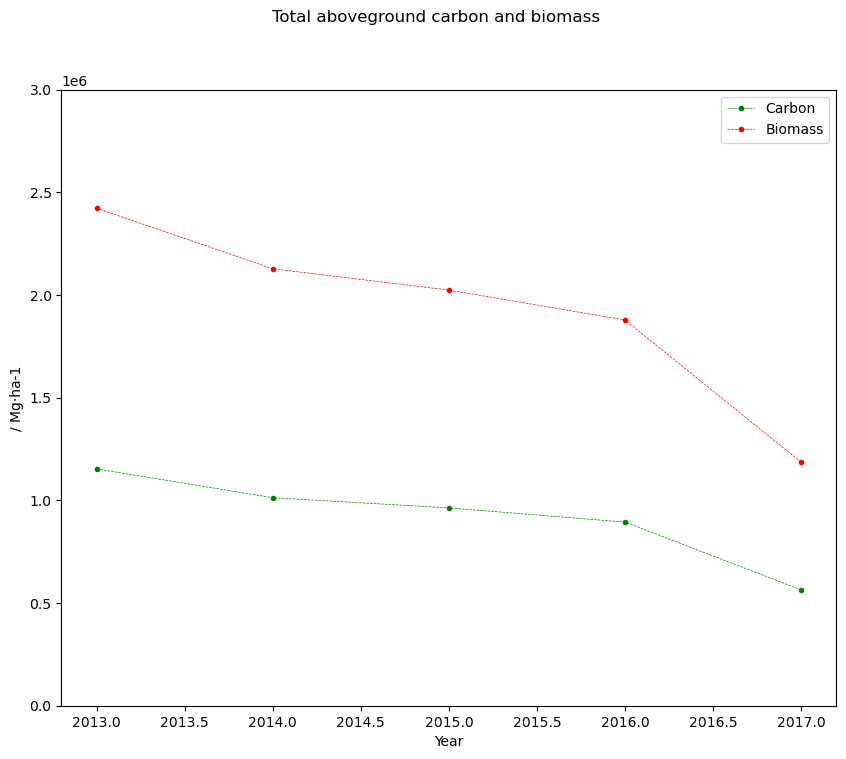

In [55]:
# Plot average values for the area of interest over time
fig, ax = plt.subplots(figsize=(10, 8), nrows=1, ncols=1, sharex=True)

# Carbon
ax.plot(
    statistics_df["carbon.sum"],
    linestyle="--",
    marker=".",
    color="g",
    linewidth=0.5,
    label="Carbon"
)
ax.set_ylim(0, 3e6)

# Biomass
ax.plot(
    statistics_df["biomass.sum"],
    linestyle="--",
    marker=".",
    color="r",
    linewidth=0.5,
    label= "Biomass"
)

ax.set_ylabel("/ Mg⋅ha-1")
ax.set_xlabel("Year")

plt.gca().legend()
plt.suptitle("Total aboveground carbon and biomass")
plt.show()

## Download to csv

In the following cell, we will download the results stored in the `pandas` dataframe as a .csv file. If you wish to download the raw data from the requests (Statistical or Processing APIs), simply add the `save_data=True` flag to when executing them, such as:

- `sum_response = carbonsum.get_data(save_data=True)`
- `statistical_response = request.get_data(save_data=True)`



In [56]:
# Download pandas as csv
statistics_df.to_csv("./fcd_statistics.csv")

## 3. Extract statistics filtering for forest cover

In the following cells we will extract statistics using Sentinel Hub's [Statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/) and parse the results into a Dataframe, as we did in Step 1. The difference here is that within the [Evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) we will filter out results based on a binary forest mask. 

The binary forest mask is based on user-specified thresholds for height and cover, and can be adjusted in the Evalscript.

After converting the results to a `pandas` Dataframe, we will compare the statistics with the previous data that don't account for the presence of forested / non-forested areas. This will provide better insights into the evolution of the forested cover over the parcel of interest.

In [57]:
evalscript_masked_stats = """
//VERSION=3

// Set threshold for height (in meters) and cover (in %) to map forest
const heightThreshold = 5
const coverThreshold = 50

// Set constants
const BIOMASS_CONV = 0.476

function setup() {
    return {
        input: [{
            datasource: "canopyHeight",
            bands: ["CH", "dataMask"]
        },
        {
            datasource: "canopyCover",
            bands: ["CC", "dataMask"]
        },
        {
            datasource: "carbon",
            bands: ["ACD", "dataMask"]
        }
        ],
        output: [
            { id: "canopyHeight", bands: 1, sampleType: "UINT8" },
            { id: "canopyCover", bands: 1, sampleType: "UINT8" },
            { id: "carbon", bands: 1, sampleType: "UINT16" },
            { id: "biomass", bands: 1, sampleType: "FLOAT32" },
            { id: "dataMask", bands: 1, sampleType: "UINT8" }
        ],
        mosaicking: "ORBIT"
    };
}

function evaluatePixel(samples) {
    var sampleHeight = samples.canopyHeight[0].CH
    var nodataHeight = samples.canopyHeight[0].dataMask
    var sampleCover = samples.canopyCover[0].CC
    var nodataCover = samples.canopyCover[0].dataMask
    var sampleCarbon = samples.carbon[0].ACD
    var nodataCarbon = samples.carbon[0].dataMask

    // Biomass simple scalar conversion
    var sampleBiomass = sampleCarbon / BIOMASS_CONV

    // Compute forest mask
    var forestMask = 0
    if (sampleHeight >= heightThreshold && sampleCover >= coverThreshold) {
        // Where the map matches criteria, set to 1
        forestMask = 1
    }

    // Combined noData / Forest mask
    var combinedMask = forestMask * nodataHeight * nodataCover * nodataCarbon

    return {
        canopyHeight: [sampleHeight],
        canopyCover: [sampleCover],
        carbon: [sampleCarbon],
        biomass: [sampleBiomass],
        dataMask: [combinedMask]
    };
}
"""

In [58]:
# Payload
masked_request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript_masked_stats,
        time_interval=(f"{start_year}-01-01T00:00:00Z", f"{end_year}-12-31T23:59:59Z"),
        # To fetch the yearly data that is set to 1 date / year we set the aggregation to P1D
        aggregation_interval="P1D",
        # Match the resolution of the PV (30 meters). Beware: resolution should be in the units of the coordinate system used
        resolution=[30, 30],
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            height_collection,
            identifier="canopyHeight",
        ),
        SentinelHubStatistical.input_data(
            cover_collection,
            identifier="canopyCover",
        ),
        SentinelHubStatistical.input_data(
            carbon_collection,
            identifier="carbon",
        ),
    ],
    geometry=parcel_geo,
    config=config,
)

In [60]:
# Run the request and display a sample of the data returned
statistical_response_masked = masked_request.get_data()
statistical_response_masked

[{'data': [{'interval': {'from': '2013-01-01T00:00:00Z',
     'to': '2013-01-02T00:00:00Z'},
    'outputs': {'biomass': {'bands': {'B0': {'stats': {'min': 52.5210075378418,
         'max': 237.39495849609375,
         'mean': 141.26000018434505,
         'stDev': 43.87441537252077,
         'sampleCount': 51975,
         'noDataCount': 36643}}}},
     'carbon': {'bands': {'B0': {'stats': {'min': 25.0,
         'max': 113.0,
         'mean': 67.23975997912842,
         'stDev': 20.88422148822174,
         'sampleCount': 51975,
         'noDataCount': 36643}}}},
     'canopyHeight': {'bands': {'B0': {'stats': {'min': 5.0,
         'max': 29.0,
         'mean': 16.379728672058445,
         'stDev': 5.570816416234815,
         'sampleCount': 51975,
         'noDataCount': 36643}}}},
     'canopyCover': {'bands': {'B0': {'stats': {'min': 50.0,
         'max': 95.0,
         'mean': 80.29819984346501,
         'stDev': 9.199681501464607,
         'sampleCount': 51975,
         'noDataCount':

### Sorting the data

Similarly to the previous Statistical API request, in the next cell we will convert the json response into a tabular form using a `pandas` dataframe.

In [61]:
# Convert to geopandas
masked_forest_df = pd.json_normalize(statistical_response_masked[0]['data'])

# Populate a year column
masked_forest_df['year'] = pd.to_datetime(masked_forest_df['interval.from']).dt.year

# Drop unecessary columns
masked_forest_df = masked_forest_df.drop(columns=['interval.from', 'interval.to'])

# Rename columns
masked_forest_df.columns = masked_forest_df.columns.str.replace('outputs.', '').str.replace('.bands.B0.stats', '')

# Set index
masked_forest_df.set_index('year', inplace=True)

# Show the new Dataframe with the results
masked_forest_df

,biomass.min,biomass.max,biomass.mean,biomass.stDev,biomass.sampleCount,biomass.noDataCount,carbon.min,carbon.max,carbon.mean,carbon.stDev,...,canopyHeight.mean,canopyHeight.stDev,canopyHeight.sampleCount,canopyHeight.noDataCount,canopyCover.min,canopyCover.max,canopyCover.mean,canopyCover.stDev,canopyCover.sampleCount,canopyCover.noDataCount
year,,,,,,,,,,,,,,,,,,,,,
2013,52.521008,237.394958,141.260000,43.874415,51975,36643,25.0,113.0,67.239760,20.884221,...,16.379729,5.570816,51975,36643,50.0,95.0,80.298200,9.199682,51975,36643
2014,52.521008,226.890762,127.556023,50.572164,51975,37755,25.0,108.0,60.716667,24.072350,...,15.132560,5.899767,51975,37755,50.0,94.0,74.665331,12.439011,51975,37755
2015,52.521008,222.689072,128.828561,48.742497,51975,39633,25.0,106.0,61.322395,23.201429,...,15.187895,5.800366,51975,39633,50.0,94.0,75.462486,11.939573,51975,39633
2016,52.521008,220.588242,131.105795,48.671830,51975,40746,25.0,105.0,62.406359,23.167791,...,16.135631,6.218184,51975,40746,50.0,92.0,74.557574,11.517228,51975,40746
2017,54.621849,203.781509,105.110214,31.569252,51975,43750,26.0,97.0,50.032462,15.026964,...,13.660912,4.458894,51975,43750,50.0,90.0,65.706626,10.607488,51975,43750


## Plot data

In the next cell we will plot the comparison between our two Statistical API queries: one for all pixels located in the parcel of interest, and the other only accounting for forest-covered pixels based on user-defined thresholds. We will plot Canopy Height and aboveground carbon.

The plot shows similar trends for both variables, although it seems that the forested areas were not so impacted by carbon loss over the period 2013 - 2016 as when we account for all types of land. However, in the last year of the time-series, we observe a loss in carbon and a significant drop in average canopy height. Of course, this analysis is for illustrative purposes only and the interpretation of the results would require a more thorough investigation.

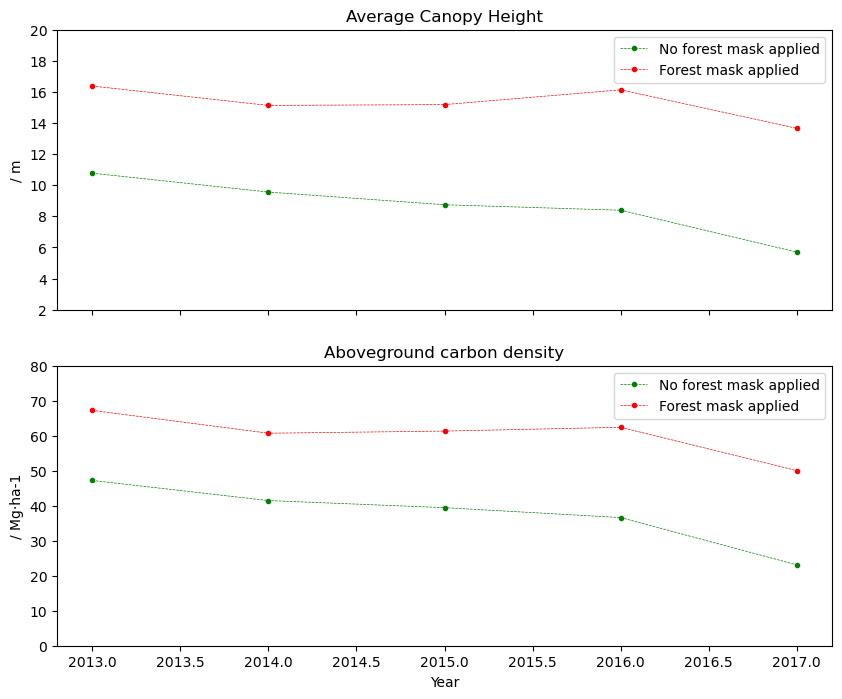

In [62]:
# Plot average values for the area of interest over time
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=1, sharex=True)

# Canopy Height
ax[0].plot(
    statistics_df["canopyHeight.mean"],
    linestyle="--",
    marker=".",
    color="g",
    linewidth=0.5,
    label="No forest mask applied"
)
ax[0].plot(
    masked_forest_df["canopyHeight.mean"],
    linestyle="--",
    marker=".",
    color="r",
    linewidth=0.5,
    label= "Forest mask applied"
)
ax[0].set_ylim(2, 20)
ax[0].set_ylabel("/ m")
ax[0].legend()
ax[0].set_title("Average Canopy Height")

# Carbon
ax[1].plot(
    statistics_df["carbon.mean"],
    linestyle="--",
    marker=".",
    color="g",
    linewidth=0.5,
    label="No forest mask applied"
)
ax[1].plot(
    masked_forest_df["carbon.mean"],
    linestyle="--",
    marker=".",
    color="r",
    linewidth=0.5,
    label= "Forest mask applied"
)
ax[1].set_ylim(0, 80)
ax[1].set_ylabel("/ Mg⋅ha-1")
ax[1].set_xlabel("Year")
ax[1].legend()
ax[1].set_title("Aboveground carbon density")

plt.show()

## Canopy Height and Cover maps

In the following cell, we will try to visually interpret the maps of Canopy Cover and Canopy Height, comparing the results in 2013 (start of the time-series), 2016 and 2017. 

In a first step, we will run a Processing API request to collect data over the period 2013-2017 for the two variables. Although we could simply request a visualisation of the variables from Sentinel Hub, in this case we will request the raw values for further analysis needs.

In a second step we will plot the images.

In [63]:
evalscript_maps = """
//VERSION=3
function setup() {
    return {
        input: [{
            datasource: "canopyHeight",
            bands: ["CH", "dataMask"]
        },
        {
            datasource: "canopyCover",
            bands: ["CC", "dataMask"]
        }],
        output: [
            { id: "canopyHeight", bands: 5, sampleType: "UINT16" },
            { id: "canopyCover", bands: 5, sampleType: "UINT16" },
        ],
        mosaicking: "ORBIT"
    };
}

function evaluatePixel(samples) {

    var sampleHeight = samples.canopyHeight
    var sampleCover = samples.canopyCover

    // Loop around samples
    let heightValue = []
    let coverValue = []

    sampleHeight.forEach((sample, index) => {
        if (sample.dataMask == 1) {
            heightValue.push(sample.CH)
        } else {
            heightValue.push(255)
        }
    });
    sampleCover.forEach((sample, index) => {
        if (sample.dataMask == 1) {
            coverValue.push(sample.CC)
        } else {
            coverValue.push(255)
        }
    });
    return {
        canopyHeight: heightValue,
        canopyCover: coverValue
    }
}
"""

In [64]:
# Payload
request_raw = SentinelHubRequest(
    evalscript=evalscript_maps,
    input_data=[
        SentinelHubStatistical.input_data(
            height_collection,
            identifier="canopyHeight",
            time_interval=("2013-01-01", "2017-12-31"),
            mosaicking_order="leastRecent",
        ),
        SentinelHubStatistical.input_data(
            cover_collection,
            identifier="canopyCover",
            time_interval=("2013-01-01", "2017-12-31"),
            mosaicking_order="leastRecent",
        ),
    ],
    responses=[
        SentinelHubRequest.output_response("canopyHeight", MimeType.TIFF),
        SentinelHubRequest.output_response("canopyCover", MimeType.TIFF),
    ],
    geometry=parcel_geo,
    resolution=(30, 30),
    data_folder=".",
    config=config,
)

In [65]:
# Run the request and display a sample of the data returned
fcd_maps = request_raw.get_data()

### Plot maps

In the next three cells we will plot Canopy Cover and height over the time period 2013-2017. 

In [66]:
# First we convert 255 (noData) to transparent for plotting purposes.
height_maps = fcd_maps[0]["canopyHeight.tif"]
cover_maps = fcd_maps[0]["canopyCover.tif"]
height_maps = np.ma.masked_where(height_maps == 255, height_maps)
cover_maps = np.ma.masked_where(cover_maps == 255, cover_maps)

### Canopy Cover

By plotting the Canopy Cover over the the entire time-series, we notice the overall decrease of canopy cover over time, with a sudden drop between 2016 and 2017.  This confirms the statistical data that we plotted previously.

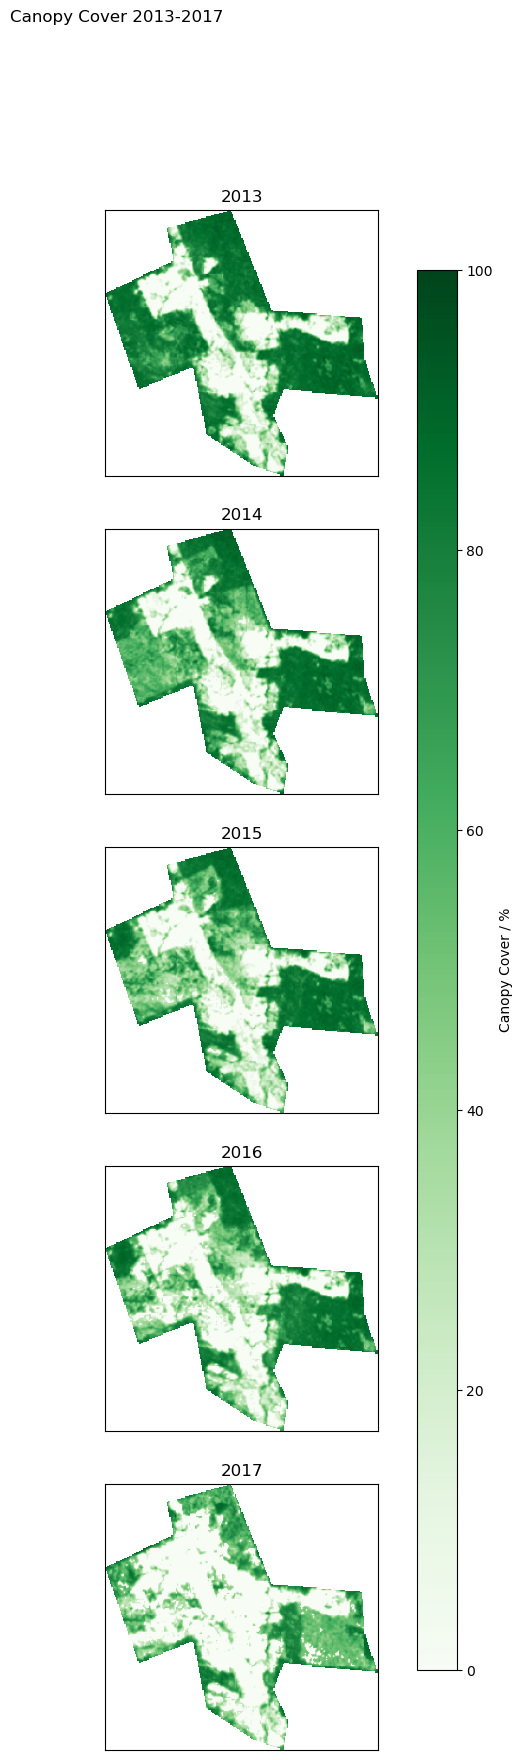

In [67]:
# Plot average values for the area of interest over time
fig, ax = plt.subplots(figsize=(20, 20), nrows=5, ncols=1, sharex=True)

# Set color ramp
sy = 2013
for i in range(height_maps.shape[2]):
    im = ax[i].imshow(cover_maps[:, :, i], cmap="Greens", vmin=0, vmax=100)
    # Titles
    ax[i].set_title(str(sy))
    sy+=1

    # Remove tickes
    ax[i].set_yticks([])
    ax[i].set_xticks([])

# Colorbar
fig.subplots_adjust(right=1)
cbar_ax = fig.add_axes([0.65, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Canopy Cover / %")

plt.suptitle("Canopy Cover 2013-2017")

plt.show()

### Canopy Height

The successive losses in Canopy between 2013 and 2017 are also visible when looking at the Canopy Height maps for the parcel of interest. However, it is interesting to note that in the eastern part of the AOI, there is a significant drop in Canopy height without there being deforestation (halving of the average canopy height). More analysis would be needed to understand the causes of this phenomenon.

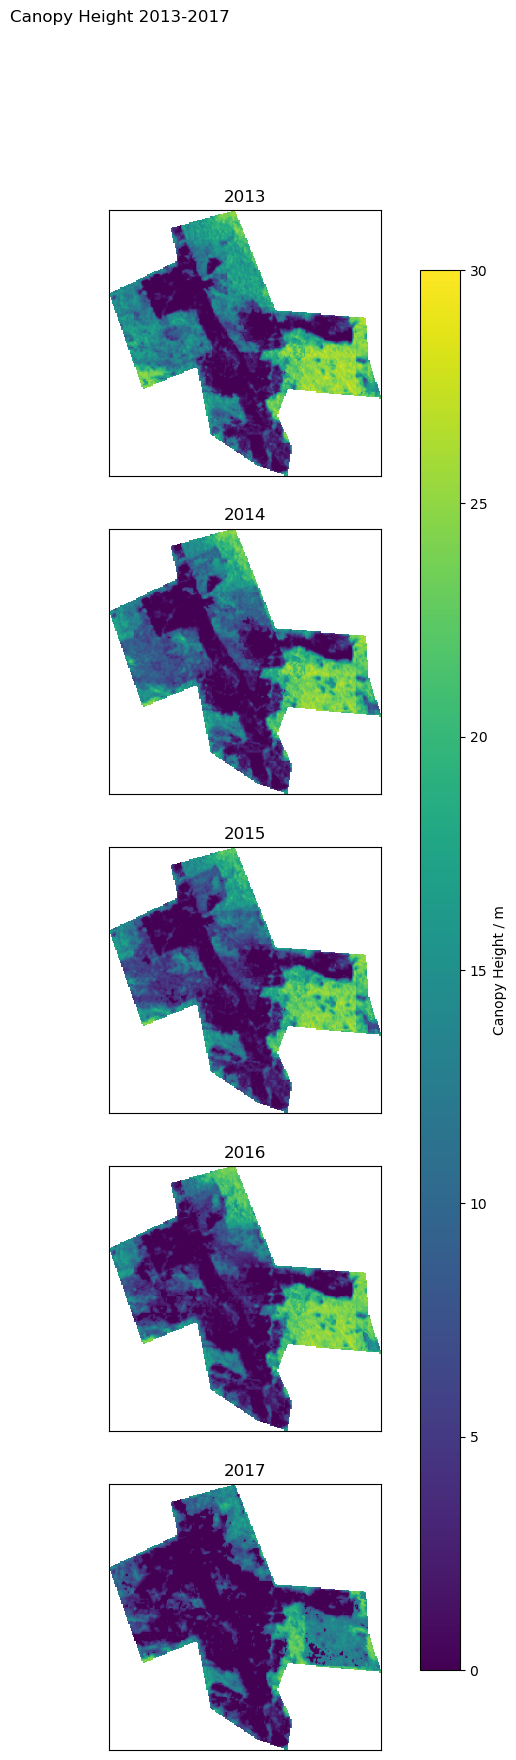

In [68]:
# Plot average values for the area of interest over time
fig, ax = plt.subplots(figsize=(20, 20), nrows=5, ncols=1, sharex=True)

# Set color ramp
sy = 2013
for i in range(height_maps.shape[2]):
    im = ax[i].imshow(height_maps[:, :, i], cmap="viridis", vmin=0, vmax=30)
    # Titles
    ax[i].set_title(str(sy))
    sy+=1

    # Remove tickes
    ax[i].set_yticks([])
    ax[i].set_xticks([])

# Colorbar
fig.subplots_adjust(right=1)
cbar_ax = fig.add_axes([0.65, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Canopy Height / m")

plt.suptitle("Canopy Height 2013-2017")
plt.show()